In [3]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

import os

from sklearn.model_selection import train_test_split
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

import itertools

# 일별 대여량


## 0. Data Load

In [ ]:
df = pd.read_csv('./daily_rental_amount.csv')
df.set_index(df['date'], inplace=True)
df = df.drop('date', axis=1)
df

In [ ]:
data.isnull().all(axis=1).sum()

모든 feature가 결측치인 시점이 163개 존재합니다. 이들에 대해 직전 시점의 값으로 보간하도록 하겠습니다. 

In [ ]:
data = data.fillna(method='pad')
data

### Feature 확인

특정 일자의 open, high, low, cloas, adj. closa, volume 정보를 가지고 있고 이를 plot으로 나타내보면 다음과 같습니다. 

In [ ]:
df = data

In [ ]:
df.index

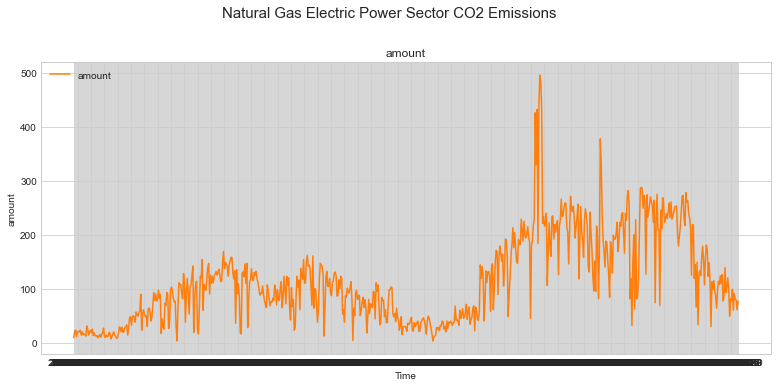

In [64]:
plt.rc('font', size=10)
fig, ax= plt.subplots(figsize=(12, 6))

ax.plot(df.amount, color='tab:orange', label='amount')
ax.set_xlabel('Time')
ax.set_ylabel("amount")
ax.set_title('amount')
ax.legend(loc='upper left')

plt.suptitle("Natural Gas Electric Power Sector CO2 Emissions", fontsize=15)
fig.tight_layout(pad=5)
plt.show()

### Data Split
data를 trian:validation:test=7:1.5:1.5로 나눠주겠습니다. 

In [65]:
val_train_data, test_data = train_test_split(df, test_size=0.15, shuffle=False) 
train_data, valid_data = train_test_split(val_train_data, test_size=1.5/8.5, shuffle=False)

In [66]:
print('Train: %f, Validation: %f, Test: %f' % (len(train_data)/len(df), len(valid_data)/len(df), len(test_data)/len(df)))

Train: 0.697902, Validation: 0.151049, Test: 0.151049


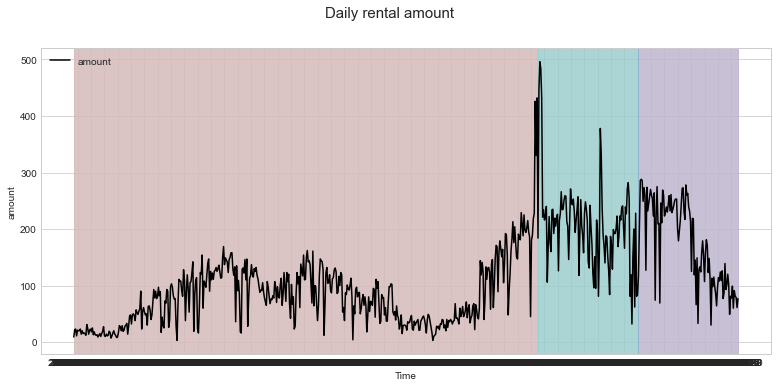

In [67]:
plt.rc('font', size=10)
fig, ax= plt.subplots(figsize=(12, 6))

ax.plot(df.amount, color='black', label='amount')
plt.axvspan(train_data.index[0], train_data.index[-1], alpha=0.2, color='lightcoral')
plt.axvspan(valid_data.index[0], valid_data.index[-1], alpha=0.2, color='darkturquoise')
plt.axvspan(test_data.index[0], test_data.index[-1], alpha=0.2, color='mediumpurple')

ax.set_xlabel('Time')
ax.set_ylabel('amount')
ax.legend(loc='upper left')

plt.suptitle("Daily rental amount", fontsize=15)
fig.tight_layout(pad=5)
plt.show()

# ARIMA Modeling Process
time series forecasting model을 만들기 위해 다음과 같은 Box-Jenkins ARIMA Procedure를 따라 진행하도록 하겠습니다.   

1. Data Preprocessing     
while: 
    2. Identify Model to be Tentatively Entertained  
    3. Estimate Parameters  
    4. Diagnosis Check  
    if model is appropriate:
        break  
5. Use Model to Forecast  

## 1. Data Preprocessing
data의 stationary함을 확인하고 autocorrelation, partial autocorrelation function의 양상을 확인해 적절한 ARIMA model 후보를 도출하겠습니다. 
### A. Seasonal Decomposition

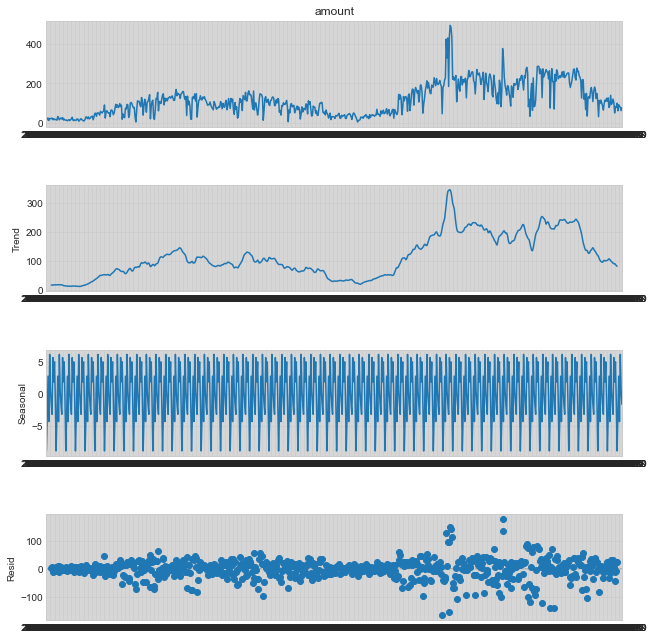

In [68]:
# google trend data
decomposition = sm.tsa.seasonal_decompose(df.amount, model = 'additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

### B. Model Identification

time series가 stationary하다는 것은 time에 상관없이 mean, variance, autocorrelation이 일정하다는 뜻으로, time에 dependent하지 않고 trend와 seasonality가 존재하지 않는 것을 뜻합니다. 대부분의 statistical forecasting method는 time series의 stationary를 가정합니다. 이는 time에 dependent한 trend와 seasonal component를 제거하여 예측하기 위해서 입니다. 

그러므로, model을 만들기에 앞서, data의 stationary를 먼저 확인하도록 하겠습니다. 

### (1) Autocorrelation function and partial autocorrelation function
이 두 함수는, time series의 현재 value가 previous value에 dependent한가에 대한 정보를 알려줍니다. 

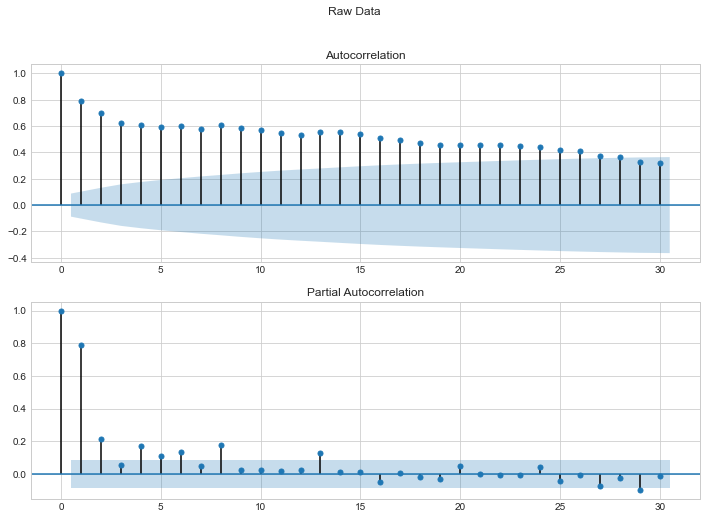

In [69]:
fig, ax = plt.subplots(2, 1, figsize = (12, 8))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])
plt.show()

Autocorrelation은 천천히 감소하여 cut-off되지 않아 data가 non-stationary함을 추정할 수 있습니다. partial autocorrelation은 lag=1이후에 cut-off 되었습니다. 

### (2) Augmented Dickey-Fuller test
ADF test를 통해 data의 stationary를 statistically 검증해보도록 하겠습니다.  

$H_0$: time series has a unit root(it is non-stationary)  
$H_1$: time series is stationary


In [70]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(train_data['amount'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   0.922085
p-value                          0.993372
#Lags Used                      12.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


test 결과, p-value=0.316>0.05이므로  따라서 significant level $\alpha=0.05$하에서 $H_0$을 reject할 statistically significant evidence가 없기 때문에 $H_0$을 reject 할 수 없어 data가 stationary하다고 할 수 없습니다.  

statistical model을 만들기 위해서는 data가 stationary해야하기 때문에 differenciation을 통해 stationary해지도록 만들어주겠습니다. 

### Differencing

In [71]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data.amount.diff()
diff_train_data = diff_train_data.dropna()  
print('------<Raw data>------')
print(train_data)
print('------<Differenced data>------')
print(diff_train_data)

------<Raw data>------
            amount
date              
2018-01-01       9
2018-01-02      22
2018-01-03      23
2018-01-04      11
2018-01-05      21
...            ...
2019-05-22     218
2019-05-23     228
2019-05-24     426
2019-05-25     330
2019-05-26     432

[499 rows x 1 columns]
------<Differenced data>------
date
2018-01-02     13.0
2018-01-03      1.0
2018-01-04    -12.0
2018-01-05     10.0
2018-01-06     -1.0
              ...  
2019-05-22     29.0
2019-05-23     10.0
2019-05-24    198.0
2019-05-25    -96.0
2019-05-26    102.0
Name: amount, Length: 498, dtype: float64


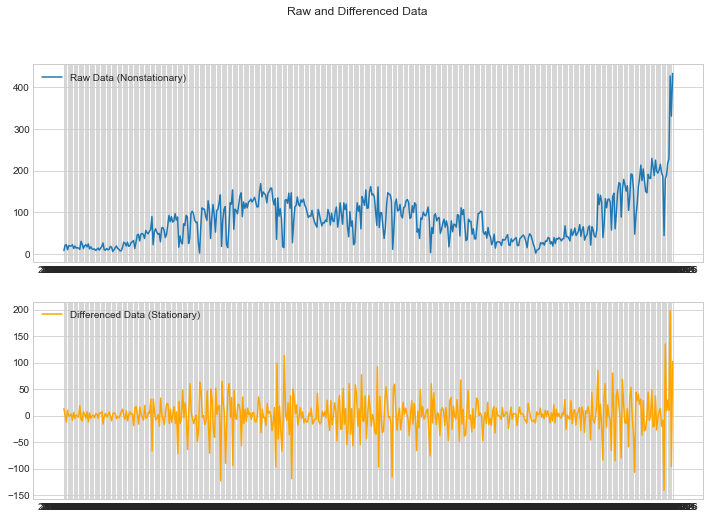

In [72]:
plt.figure(figsize=(12, 8))
plt.suptitle('Raw and Differenced Data')
plt.subplot(211)
plt.plot(train_data.amount)
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

raw data와 비교했을 때, differenced data는 time에 따라 trend와 seasonality가 보이지 않고, mean과 variance가 비교적 일정합니다.  
autocorrelation과 partial autocorrelation function plot을 통해서도 diffenced data가 stationary한지 확인해보도록 하겠습니다.

### (1) Autocorrelation function and partial autocorrelation function

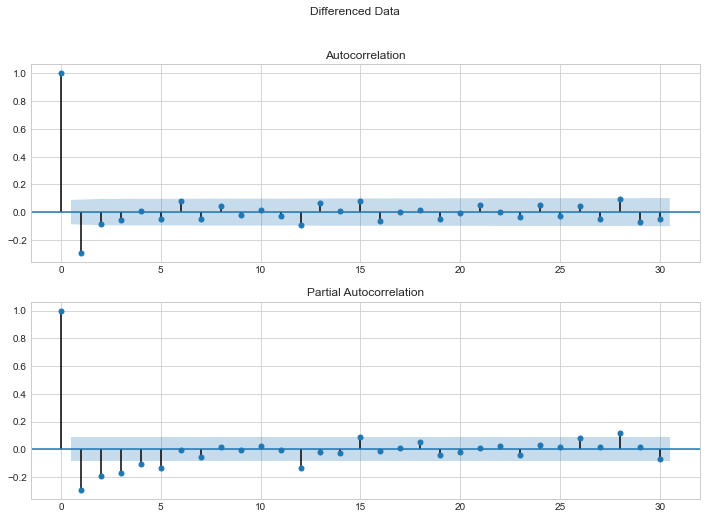

In [73]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])
plt.show()

differencing한 결과, autocorrelation, partial autocorrelation 모두 빠르게 cut-off됩니다. 

### (2) Augmented Dickey-Fuller test

In [74]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(diff_train_data)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -8.226798e+00
p-value                        6.214964e-13
#Lags Used                     1.100000e+01
Number of Observations Used    4.860000e+02
Critical Value (1%)           -3.443877e+00
Critical Value (5%)           -2.867505e+00
Critical Value (10%)          -2.569947e+00
dtype: float64


ADF test 결과도 p-value가 0에 매우 가까워 0.05보다 작다. 따라서 significant level $\alpha=0.05$하에서 $H_0$을 reject할 statistically significant evidence가 있기 때문에 $H_0$을 reject하여 data가 stationary함을 통계적으로 증명할 수 있습니다. 

## 2. Identify Model to be Tentatively Entertatined -1

Autocorrelation function, partial autocorrelation function을 기반으로 ARIMA model의 p, q를 추정하고, 각 p, q에 따른 model을 검증하도록 하겠습니다.  
d는 위에서 differencing 1번한 결과, data가 stationary해졌기 때문에, d=1로 고정하겠습니다.  

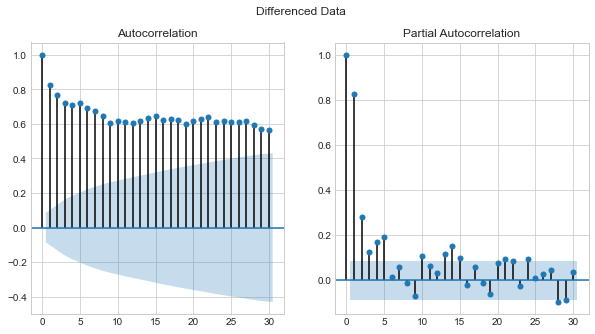

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])
plt.show()

위의 ACF, PACF를 다음과 같이 해석할 수 있습니다. 

- ACF: 모든 lag에서 autocorrelation 이 significant한 값을 가집니다.  

이는 lag=2 이상의 autocorrelation은 lag=1일 때의 autocorrelation의 propagation에 의한 것일 수 있습니다. 이를 확인하기 위해 partial autocorrelation을 보면,  

- lag=0일 때의 autocorrelation은 1이기 때문에 제외하면, lag=1일 때만 큰 값을 가지고 그 이후에는 0에 가까운 값을 가집니다.  

이것은 high-order autocorrelation 값의 대부분이 lag=1 autocorrelation에 의해 설명될 수 있다는 것을 의미합니다. 이러한 사실을 바탕으로 이 data가  p=1인 autoregressive model에 의해 설명될 수 있음을 추정할 수 있는데,  AR(1)은 $X_t=\phi X_{t-1} + a_t$로 표현할 수 있기 때문입니다. 

AR(1) model의  autocorrelation function을 유도한 식으로부터 역시 이러한 해석이 가능합니다. AR(1) model의 autocorrelation function은 h가 1보다 클 때, $\gamma_X (h) =\phi^h \gamma_X (0)$ 으로 표현는데 그에 따라 특정 lag 이후에 autocorrelation이 cut-off되지 않고 h가 증가함에 따라 exponentially decrease합니다.  이 보고서에서 분석하고자 하는 data의 ACF plot을 보면 특정 lag에서 cut-off되지 않고 exponentially decrease하고 있기 때문에 이 data를 AR(1) model로 표현할 수 있음을 예상할 수 있습니다. 

---
## ARIMA

In [75]:
# parameter search

auto_arima_model = auto_arima(train_data, start_p=10, start_q=1,\
    max_p=12, max_q=3, m=52, seasonal = True, d=1, D=1, max_P=3, max_Q=3, 
    trace = True, error_action='ignore', suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[52]             : AIC=4691.003, Time=0.83 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=4489.587, Time=16.14 sec
 ARIMA(0,1,0)(0,1,2)[52]             : AIC=4487.707, Time=39.76 sec
 ARIMA(0,1,0)(0,1,3)[52]             : AIC=4488.109, Time=56.05 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=4550.378, Time=2.63 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=4487.147, Time=8.41 sec
 ARIMA(0,1,0)(1,1,2)[52]             : AIC=4486.075, Time=57.94 sec
 ARIMA(0,1,0)(1,1,3)[52]             : AIC=4487.592, Time=190.17 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=4519.303, Time=10.50 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=4488.103, Time=71.46 sec
 ARIMA(0,1,0)(2,1,2)[52]             : AIC=4487.576, Time=99.58 sec
 ARIMA(0,1,0)(2,1,3)[52]             : AIC=4489.815, Time=196.94 sec
 ARIMA(0,1,0)(3,1,0)[52]             : AIC=4506.504, Time=29.48 sec
 ARIMA(0,1,0)(3,1,1)[52]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(3,1,2)[52]             : AIC=4489.557, Tim

In [76]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  499
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 52)   Log Likelihood               -2192.853
Date:                                 Wed, 02 Dec 2020   AIC                           4397.707
Time:                                         19:47:55   BIC                           4422.309
Sample:                                              0   HQIC                          4407.407
                                                 - 499                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3713      0.068      5.453      0.000       0.238       0.505
ma.L1         -0.8409      0.042    -20.129      0.000      -0.923      -0.759
ar.S.L52      -0.9989      0.210     -4.751      0.000      -1.411      -0.587
ma.S.L52       0.1418      1.206      0.118      0.906      -2.222       2.506
ma.S.L104     -0.8340      1.087     -0.767      0.443      -2.965       1.297
sigma2       897.3077    901.178      0.996      0.319    -868.968    2663.584
===================================================================================
Ljung-Box (Q):                       40.60   Jarque-Bera (JB):               888.78
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
prediction = auto_arima_model.predict(len(valid_data), return_conf_int=True)
predicted_value= prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(valid_data.index)
mse = mean_squared_error(valid_data, predicted_value)


Text(0.5, 0.98, 'SARIMA (1, 1, 1), (1, 1, 2, 52) Prediction Results (MSE: 22719.72)')

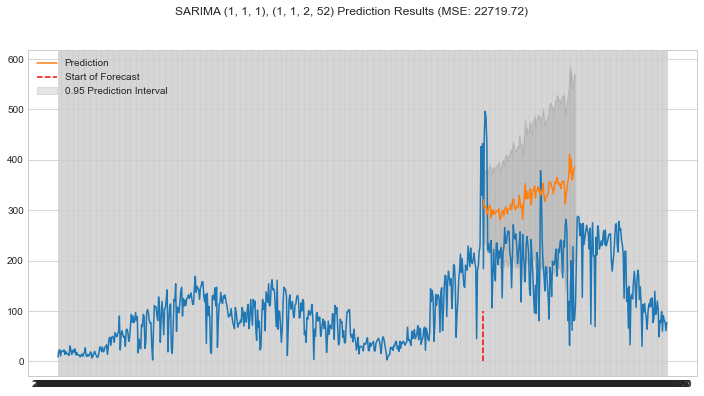

In [78]:
fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(df.index, df.values)
ax.vlines(predict_index[0], 0, 100, linestyle='--', color='r', label = 'Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label = '0.95 Prediction Interval')
ax.legend(loc='upper left')
#plt.ylim(-5, 55)
plt.suptitle(f'SARIMA {auto_arima_model.order}, {auto_arima_model.seasonal_order} Prediction Results (MSE: {round(mse, 2)})')

---
## without outlier

In [109]:
df_cleaned = pd.read_csv('./data/daily_user_cleaned.csv')
df_cleaned.set_index(df_cleaned['date'], inplace=True)
df_cleaned = df_cleaned.drop('date', axis=1)
df_cleaned = df_cleaned.rename(columns={'bike_ts_clean':'amount'})

In [110]:
val_train_data, test_data_cleand = train_test_split(df_cleaned, test_size=0.15, shuffle=False) 
train_data_cleaned, valid_data_cleand = train_test_split(val_train_data, test_size=1.5/8.5, shuffle=False)

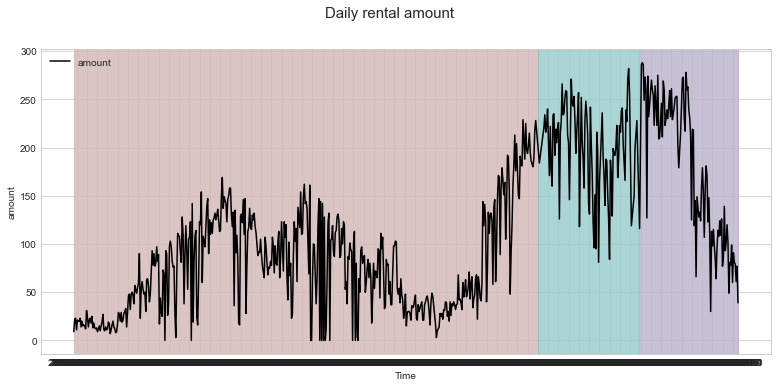

In [111]:
plt.rc('font', size=10)
fig, ax= plt.subplots(figsize=(12, 6))

ax.plot(df_cleaned.amount, color='black', label='amount')
plt.axvspan(train_data_cleaned.index[0], train_data_cleaned.index[-1], alpha=0.2, color='lightcoral')
plt.axvspan(valid_data_cleand.index[0], valid_data_cleand.index[-1], alpha=0.2, color='darkturquoise')
plt.axvspan(test_data_cleand.index[0], test_data_cleand.index[-1], alpha=0.2, color='mediumpurple')

ax.set_xlabel('Time')
ax.set_ylabel('amount')
ax.legend(loc='upper left')

plt.suptitle("Daily rental amount", fontsize=15)
fig.tight_layout(pad=5)
plt.show()

In [102]:
# parameter search

auto_arima_model = auto_arima(train_data_cleaned, start_p=1, start_q=1,\
    max_p=12, max_q=3, m=52, seasonal = True, d=1, D=1, max_P=3, max_Q=3, 
    trace = True, error_action='ignore', suppress_warnings=True, stepwise=False)

KeyboardInterrupt: 

In [ ]:
auto_arima_model.summary()

In [ ]:
prediction = auto_arima_model.predict(len(valid_data_cleaned), return_conf_int=True)
predicted_value= prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(valid_data_cleaned.index)
mse = mean_squared_error(valid_data_cleaned, predicted_value)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(df_cleaned.index, df_cleaned.values)
ax.vlines(predict_index[0], 0, 100, linestyle='--', color='r', label = 'Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label = '0.95 Prediction Interval')
ax.legend(loc='upper left')
#plt.ylim(-5, 55)
plt.suptitle(f'SARIMA {auto_arima_model.order}, {auto_arima_model.seasonal_order} Prediction Results (MSE: {round(mse, 2)})')

# Forecasting

In [172]:
train_set = pd.concat([train_data, valid_data])

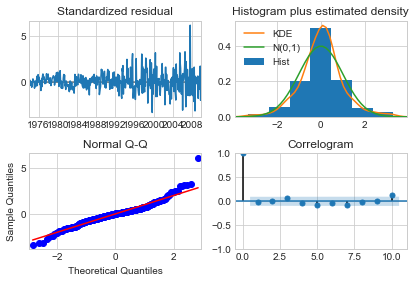

25.898303780903323 0.6526183356461451


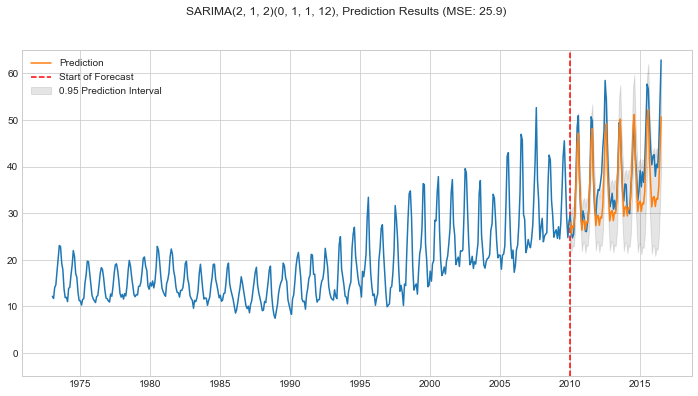

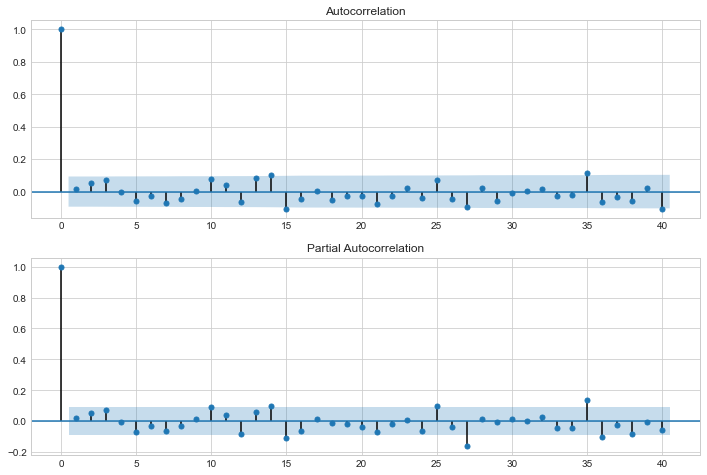

In [576]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_set,
                order=(2,1,2),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()


fig = results.plot_diagnostics()
fig.tight_layout(pad=1)
plt.show()


prediction = results.get_forecast(len(test_data))
predicted_value= prediction.predicted_mean
predicted_ub = prediction.conf_int()['upper Close']
predicted_lb = prediction.conf_int()['lower Close']
predict_index = list(test_data.index)
mse = mean_squared_error(test_data, predicted_value)
r2 = r2_score(test_data, predicted_value)
print(mse, r2)

fig, ax = plt.subplots(figsize = (12, 6))

ax.plot(df.index, df.values)
ax.vlines(predict_index[0], -10, 100, linestyle='--', color='r', label = 'Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label = '0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.ylim(-5, 65)
plt.suptitle(f'SARIMA(2, 1, 2)(0, 1, 1, 12), Prediction Results (MSE: {round(mse, 2)})')
plt.show()

resid = results.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

In [577]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  444
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -844.931
Date:                              Fri, 06 Nov 2020   AIC                           1701.862
Time:                                      05:17:34   BIC                           1726.258
Sample:                                  01-01-1973   HQIC                          1711.494
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0977      0.538     -0.182      0.856      -1.152       0.957
ar.L2          0.2962      0.307      0.964      0.335      -0.306       0.898
ma.L1         -0.2831      0.522     -0.543      0.587      -1.306       0.739
ma.L2         -0.5927      0.494     -1.200      0.230      -1.561       0.375
ma.S.L12      -0.6987      0.027    -26.360      0.000      -0.751      -0.647
sigma2         2.8880      0.117     24.711      0.000       2.659       3.117
===================================================================================
Ljung-Box (Q):                       78.61   Jarque-Bera (JB):               315.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.21   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""